In [1]:
from collections import namedtuple
from itertools import starmap

import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys

from collections import defaultdict

In [2]:
# Allow imports from parent folder
sys.path.append("..")

from compute_structures import *
from error_functions import mean_squared_error as MSE
from error_functions import root_mean_squared_error as RMSE
from error_functions import mean_absolute_relative_error as MARE
from error_functions import symmetric_mean_absolute_relative_error as SMARE
from error_functions import symmetric_mean_absolute_relative_error_alt as SMARE_alt
from error_functions import mean_my_error as mean_my_err
from error_functions import mean_log_relative_error as mean_log_err

from error_functions import absolute_error as abs_err
from error_functions import relative_error as rel_err
from error_functions import symmetric_relative_error as sym_rel_err
from error_functions import symmetric_relative_error_alt as sym_rel_err_alt
from error_functions import log_relative_error as log_rel_err
from error_functions import log_absolute_error as log_abs_err
from error_functions import squared_error as sq_err
from error_functions import my_error as my_err

In [3]:
stats_folder = "../stats/"


in_file = "training"

In [4]:
from typing import Literal, NamedTuple, NotRequired

class OverrideSetting(TypedDict):
    stats_type: StatType
    prune_strat: tuple[PruneStrat]
    sampling_rate: float
    num_histogram_buckets: NotRequired[int]

class DataRow(NamedTuple):
    override_settings: OverrideSetting
    error_data: list[float]
    actual_data: dict[str, tuple[list[int], list[int]]]
    meta_data: dict

Data = list[DataRow]

In [5]:
from typing import cast


stats_data_path = stats_folder + in_file + "_analysis.pickle"
with open(stats_data_path, "rb") as f:
    data = pickle.load(f)

# Process the data to make it easier to work with
for i in range(len(data)):
    row = data[i]
    # Make lists into tuples so they can be dict keys
    ov_sets = row[0]
    if "prune_strats" in ov_sets:
        ov_sets["prune_strats"] = tuple(ov_sets["prune_strats"])

    # Split truth and estimate into separate lists, instead of keeping them as pairs
    actual_data = row[2]
    for k, v in actual_data.items():
        actual_data[k] = tuple(zip(*v))

    # Turn the row into a DataRow
    data[i] = DataRow(*row)

data = cast(Data, data)

In [6]:
override_settings, error_data, actual_data, meta_data = zip(*data)

# Allow access to results data using string of override settings used when collecting the results data
data_by_settings = {str(row[0]): row[1:] for row in data}

def group_data_by(group_val_key: Literal["prune_strats", "stats_type", "sampling_rate"]) -> dict[OverrideSetting, Data]:
    grouped = defaultdict(list)
    for row in data:
        key_val = row.override_settings[group_val_key]
        grouped[key_val].append(row)

    return grouped

data_by_stats = group_data_by("stats_type")
data_by_pruning = group_data_by("prune_strats")
data_by_sampling = group_data_by("sampling_rate")

In [7]:
# None => allow only where key is not defined
# '*' => allow any value
# <value> => matching value
# ! Does not handle when value is None, but I don't think that can every happen here
def get_by_settings(**kwargs: OverrideSetting):
    def settings_filter(data_row: DataRow):
        ov_sets = data_row.override_settings
        for key, val in kwargs.items():
            if val != '*':
                if val is None and key in ov_sets:
                    return False
                if key not in ov_sets or ov_sets[key] != val:
                    if key in ov_sets:
                        assert type(val) == type(ov_sets[key]), f"{val} vs. {ov_sets[key]}"
                    return False
        return True

    return list(filter(settings_filter, data))

### Plotting the different error measurements [histogram(X), no sampling, no pruning]: equality

In [8]:
# histogram_stats = data_by_stats[StatType.HISTOGRAM]
# hist_no_sampling_no_pruning = [
#     row
#     for row in histogram_stats
#     if not row.override_settings["prune_strats"]
#         and row.override_settings["sampling_rate"] == 0
# ]
hist_no_sampling_no_pruning = get_by_settings(stats_type=StatType.HISTOGRAM, prune_strats=tuple(), sampling_rate=0.0)

In [9]:
error_funcs = [
    MSE, RMSE, MARE, SMARE, SMARE_alt, mean_my_err, mean_log_err
]
for err_func in error_funcs:
    result = {}
    for config_case in hist_no_sampling_no_pruning:
        test_data = config_case.actual_data
        
        errors = {}
        for operator, op_results in test_data.items():
            if not op_results: continue
            
            errors[operator] = err_func(*op_results)

        result[config_case.override_settings["num_histogram_buckets"]] = errors


    df = pd.DataFrame(result)
    # df.plot(title=err_func.__name__)




error_funcs = [
    sym_rel_err, log_rel_err, 
    # rel_err, my_err, sym_rel_err_alt
    # abs_err, log_abs_err, sq_err,  # <-- bad error measures
]
for err_func in error_funcs:
    results = {}
    for config_case in hist_no_sampling_no_pruning:
        test_data = config_case.actual_data
        
        op_results = test_data["lt"]
        n_bucks = config_case.override_settings["num_histogram_buckets"]
        errors = pd.Series(list(starmap(err_func, zip(*op_results))))

        # Outlier removal
        q = errors.quantile(0.999)
        errors = errors[errors < q]

        results[n_bucks] = errors


    df = pd.DataFrame(results)
    # df.plot(kind="box", title=err_func.__name__)

### Plotting the operators against each other with log relative error

In [56]:
def boxplot(error_collection: dict[str, list[float]], title=None):  
    errors = list(error_collection.values())
    x_labels = list(error_collection.keys())

    fig, ax = plt.subplots()
    _ = ax.boxplot(errors, labels=x_labels, showfliers=False)

    ax.set_title(title)

    plt.show()

In [57]:
data_rows = get_by_settings(prune_strats=tuple(), sampling_rate=0.9)

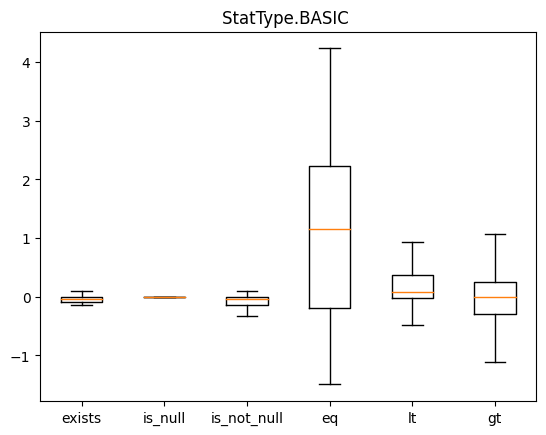

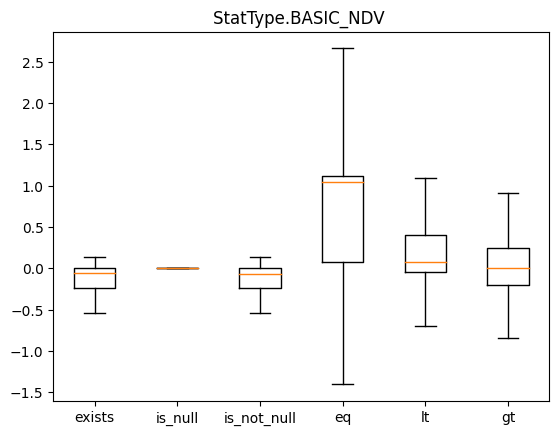

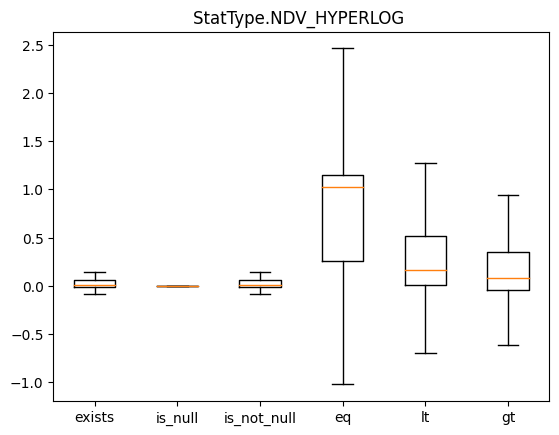

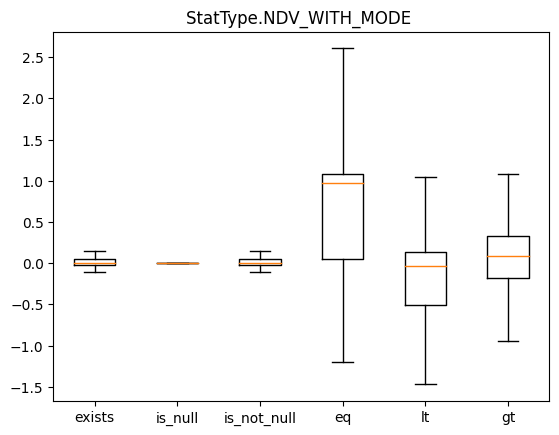

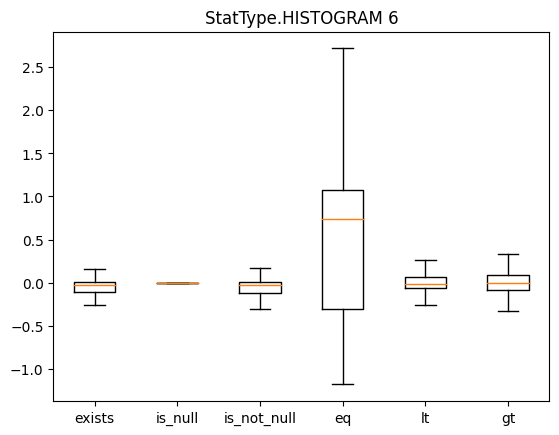

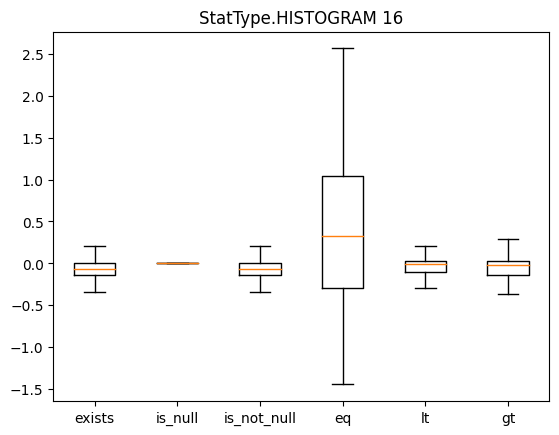

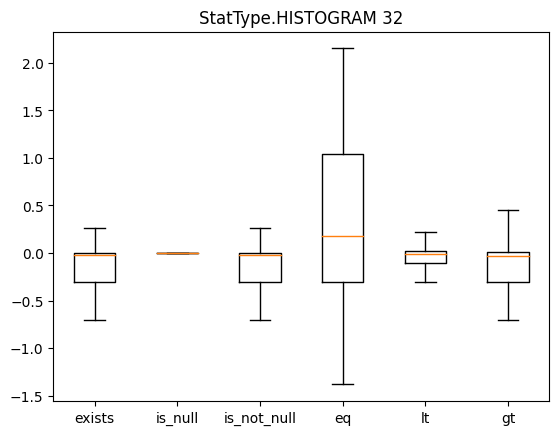

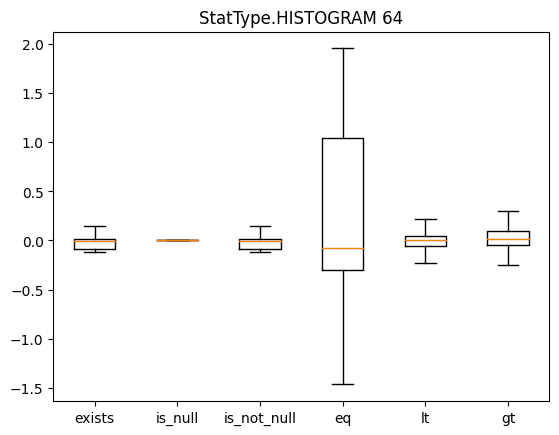

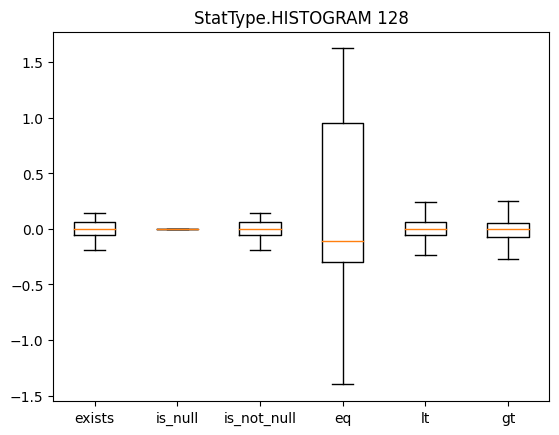

In [58]:
for datarow in data_rows:
    test_data = datarow.actual_data

    collected_errors = {}
    for operator, op_results in test_data.items():
        if not op_results: continue
        err_series = pd.Series(list(starmap(log_rel_err, zip(*op_results))))
        q = err_series.quantile(0.999)
        err_series = err_series[err_series < q]

        collected_errors[operator] = err_series

    boxplot(collected_errors, title=str(datarow.override_settings["stats_type"]) + " " + str(datarow.override_settings.get("num_histogram_buckets", "")))